In [1]:
import numpy as np
import sys
from chainer import Chain, ChainList, cuda, gradient_check, Function, Link, \
    optimizers, serializers, utils, Variable, datasets, using_config, training, iterators
from chainer.training import extensions
from chainer import functions as F
from chainer import links as L
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import scipy.special as spsp
class Func_erf2(Function): # (erf(x/sqrt(2)))   
    def forward_cpu(self, x):
        sq2 = x[0].dtype.type(np.sqrt(2.0))
        self.y = utils.force_array(spsp.erf(x[0]/sq2))
        return self.y,
    def backward_cpu(self, x, gy):
        sq2pi = x[0].dtype.type(np.sqrt(2.0/np.pi))
        two = x[0].dtype.type(2.0)
        return utils.force_array(gy[0]*sq2pi*np.exp(-x[0]*x[0]/two)),
def func_erf2(x):
    return Func_erf2()(x)


In [3]:
def is_integer_type(typ):
    try:
        xp = cuda.cupy
        return typ in [int, np.int, np.int8, np.int16, np.int32, np.int64,
                np.uint, np.uint8, np.uint16, np.uint32, np.uint64,
                xp.int8, xp.int16, xp.int32, xp.int64,
                xp.uint8, xp.uint16, xp.uint32, xp.uint64,]
    except AttributeError:
        return typ in [int, np.int, np.int8, np.int16, np.int32, np.int64,
                np.uint, np.uint8, np.uint16, np.uint32, np.uint64]

In [4]:
class MLP(ChainList):
    def __init__(self, ls, nobias, act=F.relu, opt=None):
        self.ls = ls
        self.l = []
        for i in range(len(ls)-1):
            self.l.append(L.Linear(ls[i], ls[i+1], nobias=nobias))
        super(MLP, self).__init__(*self.l)
        self.act = act
        self.opt = opt
        if opt is not None:
            self.opt.setup(self)
        self.lossfrac = np.zeros(2)
        self.accfrac = np.zeros(2)
        self.update_cnt = 0
    def __call__(self, x, mode='train'): # Variable受け取ってVariable返す
        with using_config('train', mode=='train'):
            for i in range(len(self.l)):
                x = self.l[i](x)
                if i+1<len(self.l): x = self.act(x)
        return x
    def update(self, x, t, mode='train'):  # Variable受け取ってVariable返す
        bs = x.shape[0]
        y = self(x, mode=mode)
        if is_integer_type(t.data.dtype):
            if 1: # 分類 (softmax_cross_entropy)
                if self.update_cnt == 0: print('[update] classfication with softmax cross entropy')
                loss = F.softmax_cross_entropy(y, t)
                acc = np.count_nonzero(np.argmax(y.data,axis=1)==t.data)
            elif 0: # 二値分類 (sigmoid_cross_entropy)
                if self.update_cnt == 0: print('[update] classfication with sigmoid cross entropy')
                loss = F.sigmoid_cross_entropy(y, t) # y and t has same dimension
                acc = np.count_nonzero((y.data>0).astype(np.int32)==t.data)
            else:
                raise ValueError
        else:
            if self.update_cnt == 0: print('[update] squared regression')
            # 回帰 (squared)
            loss = 0.5 * F.sum((y - t)**2) / bs
            acc = 0

        # loss は bs で割られたスカラーになっている．はず
        if mode=='train':
            self.cleargrads()
            loss.grad = np.ones(loss.shape, dtype=np.float32)
            loss.backward()
            self.opt.update()
        elif mode=='test':
            pass
        else:
            raise ValueError
        self.lossfrac += np.array([np.sum(loss.data) * bs, bs])
        self.accfrac += np.array([acc, bs])
        self.update_cnt += 1
        return loss
    def aveloss(self, clear):
        ret = self.lossfrac[0]/self.lossfrac[1]
        if clear: self.lossfrac = np.zeros(2)
        return ret
    def aveacc(self, clear):
        ret = (0.+self.accfrac[0])/self.accfrac[1]
        if clear: self.accfrac = np.zeros(2)
        return ret
    def W(self, idx):
        return self.l[idx].W.data

In [41]:
def add_noise(ary, noise_intensity, mode='multiple'):
    if mode == 'multiple':
        return ary * (1.0 + noise_intensity * np.random.randn(*ary.shape))
    raise NotImplementedError
    
# 特異領域に乗った状態のモデルを作るよ　増やす素子数一般版 (MNIST でも高いプラトーに引っ掛けられるかも！)
def increase_hidden(model, opt, nb_extra_hidden=1, noise=0):
    assert(len(model.ls)==3)
    nb_hidden_old = model.ls[1]
    nb_hidden_new = model.ls[1]+nb_extra_hidden
    ls = [model.ls[0], nb_hidden_new, model.ls[2]]
    mdl_ret = MLP(ls, nobias=True, act=model.act, opt=opt)
    # nb_hidden_new 個の新しい中間素子が，元の nb_hidden_old 個の中間素子のどの重みを引き継ぐかを，ランダムに決定する．
    # ただし，全てのnb_hidden_old 個の中間素子は必ず1回ずつ以上は引き継がれないといけないことに注意する．
    assignment = np.concatenate([np.arange(nb_hidden_old), np.random.choice(nb_hidden_old, nb_extra_hidden)])
    cnt = Counter(assignment)
    new_l0 = np.copy(model.W(0)[assignment,:])
    new_l1 = np.copy(np.vstack([model.W(1)[:,assignment[i]]/cnt[assignment[i]]   for i in range(nb_hidden_new)]).T)
    
    mdl_ret.l[0].W.data = add_noise(new_l0, noise)
    mdl_ret.l[1].W.data = add_noise(new_l1, noise)
    return mdl_ret

In [6]:
def learn(mdl, mdl_t, sigma=None, nb_iter=1, bs=100, aveloss_period=100):
    if sigma is None:
        sigma = np.eye(mdl.ls[0])
    loss = []
    for i in tqdm(range(nb_iter)):
        x = Variable(np.random.multivariate_normal(np.zeros(mdl.ls[0]), sigma, bs).astype(np.float32))
        t = mdl_t(x)
        mdl.update(x, t, mode='train')
        if (i+1)%aveloss_period==0:
            loss.append([i+1, mdl.aveloss(clear=True)])
    return np.array(loss)

def learn_dataset(mdl, tuple_dataset, nb_epoch=1, bs=100):
    loss = []
    for i in tqdm(range(nb_epoch)):
        shuffled_idx = np.random.shuffle(len(tuple_dataset))
        for j in range(0, len(tuple_dataset), bs):
            minibatch_idx = shuffled_idx[j:j+bs]
            x = Variable(np.array([tuple_dataset[k][0] for k in minibatch_idx]))
            t = Variable(np.array([tuple_dataset[k][1] for k in minibatch_idx]))
            mdl.update(x, t, mode='train')
        loss.append([i+1, mdl.aveloss(clear=True)])
    return np.array(loss)  

In [56]:
# 特異領域へ人為的に近づける実験
N = 100
act = func_erf2
mdl_t = MLP([N, 2, 1], nobias=True, act=act)
mdl_degen = MLP([N, 1, 1], nobias=True, act=act, opt=optimizers.MomentumSGD())
loss = learn(mdl_degen, mdl_t, bs=100, nb_iter=10000)

[update] squared regression



In [63]:
# 中間層を増やしたモデルを作成
mdl = increase_hidden(mdl_degen, opt=optimizers.MomentumSGD(), noise=1e-5)

In [64]:
# その学習（bs=1: オンライン学習とする．）
loss2 = learn(mdl, mdl_t, bs=100, nb_iter=20000)
loss2[:,0] += loss[-1,0] # 時間オフセットを足している．

[update] squared regression



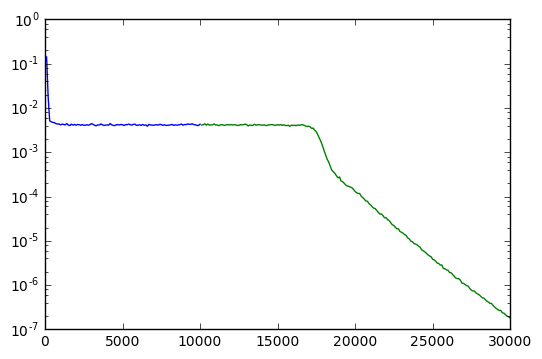

In [65]:
plt.plot(loss[:,0], loss[:,1])
plt.plot(loss2[:,0], loss2[:,1])
plt.yscale('log')
plt.show()

In [61]:
#ちなみに，普通にやると：
mdl_ref = MLP([N, 2, 1], nobias=True, act=act, opt=optimizers.MomentumSGD())
loss_ref = learn(mdl_ref, mdl_t, nb_iter=30000)

[update] squared regression



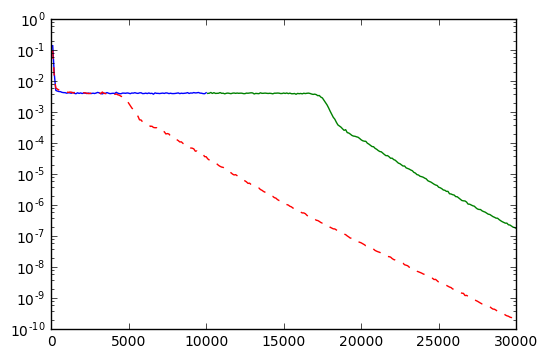

In [66]:
plt.plot(loss[:,0], loss[:,1])
plt.plot(loss2[:,0], loss2[:,1])
plt.plot(loss_ref[:,0], loss_ref[:,1], linestyle='--')
plt.yscale('log')
plt.show()

In [20]:
# N-4-1 を N-2-1 や N-1-1 に引っ掛ける事もできるのかしら．

In [ ]:
N = 100
act = func_erf2
mdl_t = MLP([N, 4, 1], nobias=True, act=act)
print(mdl_t.W(1))

In [80]:
%%time
# 特異領域へ人為的に近づける実験
mdl_degen = MLP([N, 2, 1], nobias=True, act=act, opt=optimizers.MomentumSGD())
loss = learn(mdl_degen, mdl_t, bs=100, nb_iter=10000)
# 中間層を増やしたモデルを作成
mdl = increase_hidden(mdl_degen, opt=optimizers.MomentumSGD(), nb_extra_hidden=2, noise=1e-5)
# その学習
loss2 = learn(mdl, mdl_t, bs=100, nb_iter=10000)
loss2[:,0] += loss[-1,0] # 時間オフセットを足している．

[[-0.15841468  0.21107577 -0.64622396 -0.32196864]]
[update] squared regression

[update] squared regression

CPU times: user 2min, sys: 25.1 s, total: 2min 25s
Wall time: 1min 17s


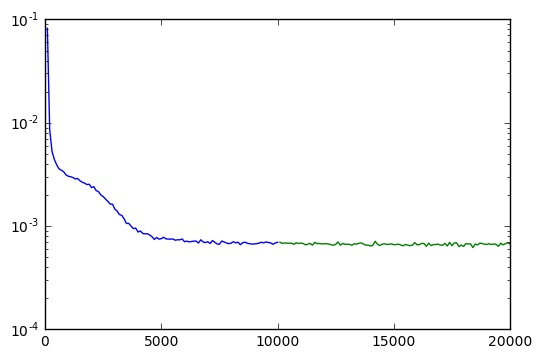

In [81]:
plt.plot(loss[:,0], loss[:,1])
plt.plot(loss2[:,0], loss2[:,1])
plt.yscale('log')
plt.show()

In [82]:
#ちなみに，普通にやると：
mdl_ref = MLP([N, 4, 1], nobias=True, act=act, opt=optimizers.MomentumSGD())
loss_ref = learn(mdl_ref, mdl_t, bs=100, nb_iter=200000)

[update] squared regression



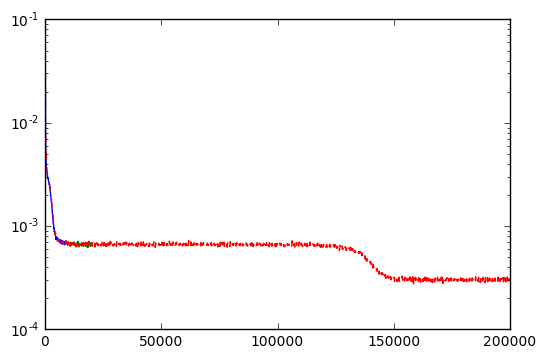

In [83]:
plt.plot(loss[:,0], loss[:,1])
plt.plot(loss2[:,0], loss2[:,1])
plt.plot(loss_ref[:,0], loss_ref[:,1], linestyle='--')
plt.yscale('log')
plt.show()

普通にやっても全部のプラトーに引っかかっていくのか？

In [84]:
#ちなみに，Adamでやると ：
mdl_ref2 = MLP([N, 4, 1], nobias=True, act=act, opt=optimizers.Adam())
loss_ref2 = learn(mdl_ref2, mdl_t, bs=100, nb_iter=200000)

[update] squared regression



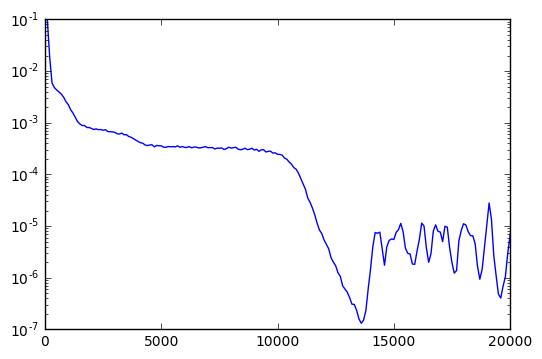

In [88]:
plt.plot(loss_ref2[:,0], loss_ref2[:,1])
plt.yscale('log')
plt.xlim(0, 20000)
plt.show()

3段階あるように見える．（N-1-1, N-2-1, N-3-1だろうか？）最後の振動は，おそらく数値的なアレ．

Adam はプラトーを明らかに短縮するようだ．（ただし引っかからなくなるわけではない．）

In [18]:
# Σを MNISTのそれに変えると？

def get_mnist_lambdas():
    train, test = datasets.get_mnist()
    ary = np.array([data[0] for data in train]).astype(np.float64) # (60000, 784)
    return np.sort(np.linalg.svd(ary, compute_uv=False) ** 2) / ary.shape[0]
mnist_lambdas = get_mnist_lambdas()

In [19]:
def name2idx(s):
    if s[:6]=='setosa': return 0
    elif s[:10]=='versicolor': return 1
    else: return 2
def get_iris_data():
    with open('iris.csv', 'r') as f:
        lines = f.readlines()
    data = []
    for line in lines[1:]:
        datum = line.split(',')
        data.append((np.array(list(map(float, datum[:4]))), name2idx(datum[4])))
    return data
def get_iris_lambdas():
    train = get_iris_data()
    ary = np.array([data[0] for data in train]).astype(np.float64) # (150, 4)
    return np.sort(np.linalg.svd(ary, compute_uv=False) ** 2) / ary.shape[0]
iris_lambdas = get_iris_lambdas()

[update] squared regression

[update] squared regression

[update] squared regression



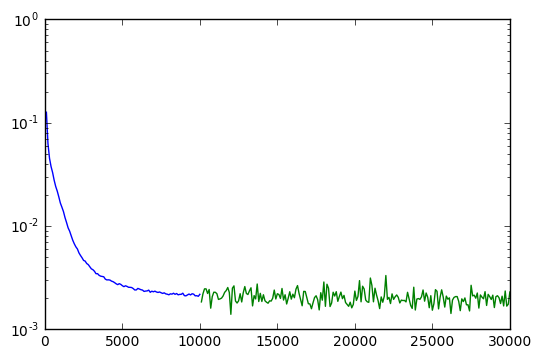

In [149]:
lambdas = mnist_lambdas[0:700:7] * 250 # MNIST-like x250
sigma = np.diag(lambdas)

# 特異領域へ人為的に近づける実験
N = 100
act = func_erf2
mdl_t = MLP([N, 2, 1], nobias=True, act=act)
mdl_degen = MLP([N, 1, 1], nobias=True, act=act, opt=optimizers.SGD(lr=0.01))
loss = learn(mdl_degen, mdl_t, sigma, bs=100, nb_iter=10000)

# 中間層を増やしたモデルを作成
mdl = increase_hidden(mdl_degen, noise=1e-3)

# その学習（bs=1: オンライン学習とする．）
loss2 = learn(mdl, mdl_t, sigma, bs=1, nb_iter=20000)
loss2[:,0] += loss[-1,0] # 時間オフセットを足している．

#ちなみに，普通にやると：
mdl_ref = MLP([N, 2, 1], nobias=True, act=act, opt=optimizers.SGD(lr=0.01))
loss_ref = learn(mdl_ref, mdl_t, sigma, nb_iter=30000)

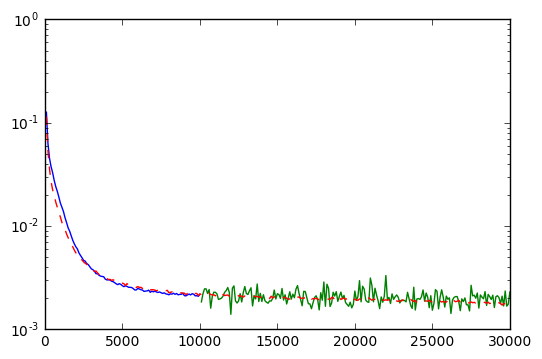

In [150]:
plt.plot(loss[:,0], loss[:,1])
plt.plot(loss2[:,0], loss2[:,1])
plt.plot(loss_ref[:,0], loss_ref[:,1], linestyle='--')
plt.yscale('log')
plt.show()

In [153]:
lambdas = np.r_[iris_lambdas, np.array([iris_lambdas[-1]]*(N-4)),]  # IRIS-like
sigma = np.diag(lambdas)

# 特異領域へ人為的に近づける実験
N = 100
act = func_erf2
mdl_t = MLP([N, 2, 1], nobias=True, act=act)
mdl_degen = MLP([N, 1, 1], nobias=True, act=act, opt=optimizers.SGD(lr=0.01))
loss = learn(mdl_degen, mdl_t, sigma, bs=100, nb_iter=10000)

# 中間層を増やしたモデルを作成
mdl = increase_hidden(mdl_degen, noise=1e-3)

# その学習（bs=1: オンライン学習とする．）
loss2 = learn(mdl, mdl_t, sigma, bs=1, nb_iter=20000)
loss2[:,0] += loss[-1,0] # 時間オフセットを足している．

#ちなみに，普通にやると：
mdl_ref = MLP([N, 2, 1], nobias=True, act=act, opt=optimizers.SGD(lr=0.01))
loss_ref = learn(mdl_ref, mdl_t, sigma, nb_iter=30000)

[update] squared regression

[update] squared regression

[update] squared regression



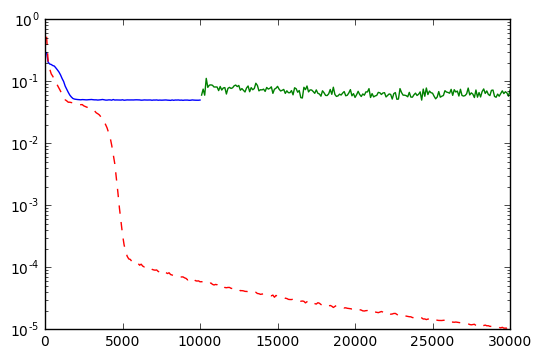

In [154]:
plt.plot(loss[:,0], loss[:,1])
plt.plot(loss2[:,0], loss2[:,1])
plt.plot(loss_ref[:,0], loss_ref[:,1], linestyle='--')
plt.yscale('log')
plt.show()